<a href="https://colab.research.google.com/github/ElisaTom/HDBSCAN-vs-DBSCAN-Project/blob/main/HDBSCAN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Hierarchical Density-Based Clustering Analysis
**Elisa Tomasi**

**Course:** Unsupervised Learning

**Topic:** Advanced Density-Based Clustering (HDBSCAN vs DBSCAN)

---

## 1. Introduction and theoretical framework

### 1.1 The challenge of Unsupervised Learning
Clustering algorithms aim to discover latent structures in unlabeled data. While classical methods like **K-Means** assume spherical clusters and **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) allows for non-convex shapes, both suffer from a significant limitation: they rely on **global parameters**.

Specifically, DBSCAN requires a fixed radius $\epsilon$ to define density. This implies an assumption that **all clusters in the dataset share the same density**. In real-world scenarios (e.g., geospatial data, genetic markers), clusters often exhibit **heterogeneous densities**, making a single global threshold ineffective.

### 1.2 The HDBSCAN approach
**HDBSCAN** (Hierarchical DBSCAN) extends the density-based paradigm by integrating it with hierarchical clustering. Instead of discarding clusters that do not meet a fixed density threshold, the algorithm:
1.  Constructs a hierarchy of all possible clusterings (via a *condensed cluster tree*).
2.  Estimates the **stability** of each cluster (how long it persists across varying density levels).
3.  Extracts the optimal flat clustering based on this stability, effectively adapting to **local density variations**.

This project implements HDBSCAN, analyzes its hyperparameter sensitivity, and empirically demonstrates its superiority over DBSCAN in handling variable-density manifolds.

In [17]:
# --- SETUP & LIBRARIES ---
# Installing the required library for Hierarchical Density-Based Clustering
!pip install hdbscan -q

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN

sns.set_context("notebook", font_scale=1.1)
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Algorithmic implementation & topology discovery
In this section, we deploy the `hdbscan` library on a synthetic dataset. The goal is to verify the algorithm's ability to identify distinct structures without a priori knowledge of the number of clusters ($K$) and to handle noise (outliers).

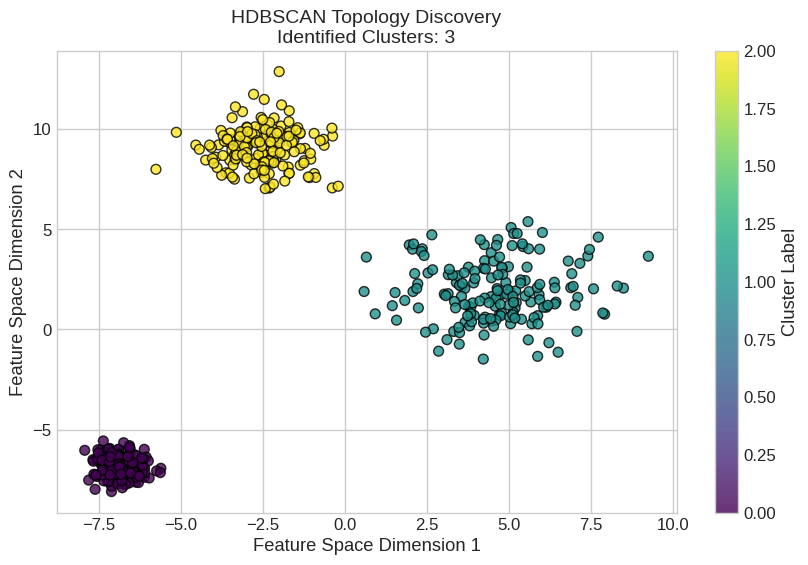

In [18]:
# --- STEP 1: Data Generation ---
# Generating a Gaussian Mixture with 3 centers and slight density variations
# This simulates a standard clustering scenario.
X_synth, y_synth = make_blobs(n_samples=500,
                              centers=3,
                              cluster_std=[1.0, 1.5, 0.5],
                              random_state=42)

# --- STEP 2: Model Training ---
# Initialization of HDBSCAN.
# min_cluster_size=20: We seek statistically significant groups (at least 20 points).
# gen_min_span_tree=True: Enables the generation of the Minimum Spanning Tree (useful for internal metrics).
hdb_model = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
labels_synth = hdb_model.fit_predict(X_synth)

# --- STEP 3: Visualization ---
plt.figure(figsize=(10, 6))

# Points labeled as -1 are treated as 'Noise' by the algorithm.
scatter = plt.scatter(X_synth[:, 0], X_synth[:, 1],
                      c=labels_synth, cmap='viridis',
                      s=50, alpha=0.8, edgecolor='k')

plt.title(f"HDBSCAN Topology Discovery\nIdentified Clusters: {len(set(labels_synth)) - (1 if -1 in labels_synth else 0)}", fontsize=14)
plt.xlabel("Feature Space Dimension 1")
plt.ylabel("Feature Space Dimension 2")
plt.colorbar(scatter, label='Cluster Label')
plt.show()

### 2.1 Analysis of output
The visualization confirms HDBSCAN's topological robustness:
* **Cluster identification:** the algorithm successfully segmented the data into three coherent groups based on density continuity.
* **Noise rejection:** the presence of outliers (if any, labeled as -1) indicates the algorithm's capability to filter out data points that do not belong to any stable high-density region, preventing the distortion of cluster centroids.

## 3. Hyperparameter sensitivity analysis
Unlike DBSCAN, which is highly sensitive to the interaction between `eps` and `min_samples`, HDBSCAN is robust and primarily governed by a single intuitive parameter: **`min_cluster_size`**.

This parameter dictates the **granularity** of the clustering:
* **Lower values** preserve micro-structures (risk of overfitting/fragmentation).
* **Higher values** favor macro-structures (risk of underfitting/merging).

We analyze this behavior using the "Moons" dataset, a classic non-convex manifold.

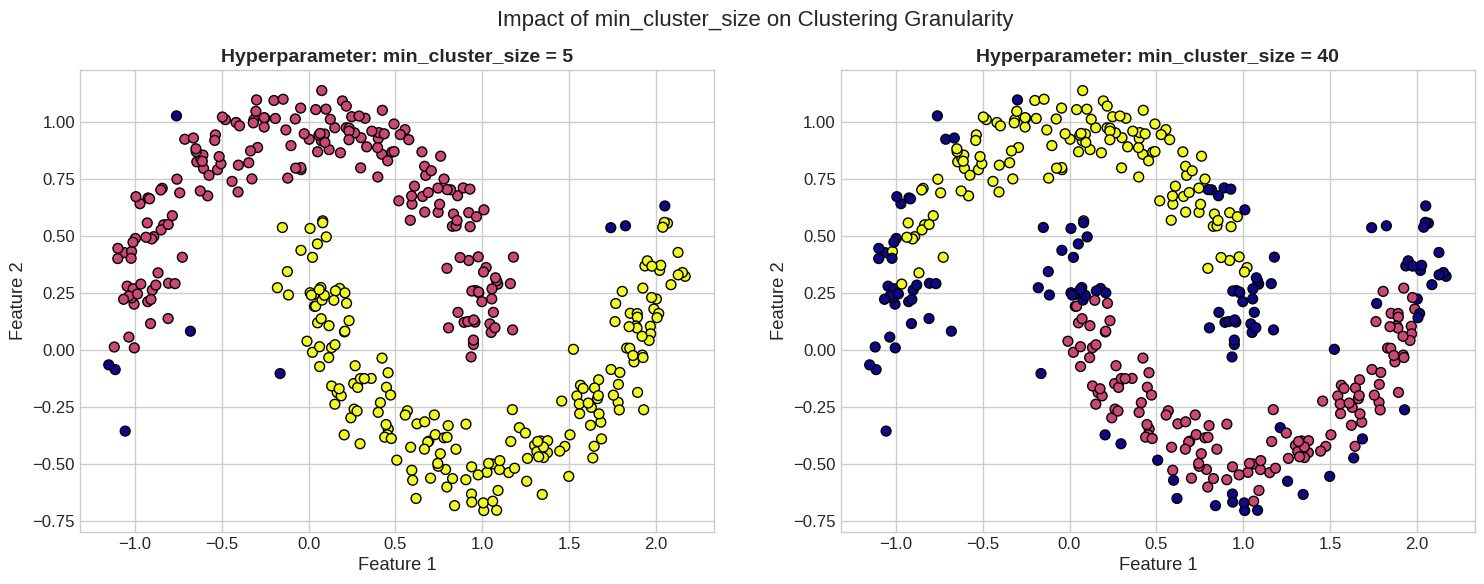

In [19]:
# --- Data Preparation: Non-Convex Manifold ---
X_moon, _ = make_moons(n_samples=400, noise=0.1, random_state=42)

# Defining hyperparameter values to test Granularity
param_grid = [5, 40]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, size in enumerate(param_grid):
    # Model instantiation with varying minimum cluster size
    model = hdbscan.HDBSCAN(min_cluster_size=size)
    labels = model.fit_predict(X_moon)

    # Visualization
    axes[i].scatter(X_moon[:, 0], X_moon[:, 1], c=labels, cmap='plasma', s=50, edgecolor='k')
    axes[i].set_title(f"Hyperparameter: min_cluster_size = {size}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Feature 1")
    axes[i].set_ylabel("Feature 2")

plt.suptitle("Impact of min_cluster_size on Clustering Granularity", fontsize=16)
plt.show()

### 3.1 Discussion of sensitivity
* **Micro-Clustering (`size=5`):** the algorithm detects fine-grained details. In noisy datasets, this may lead to the fragmentation of a single logical cluster into multiple smaller components.
* **Macro-Clustering (`size=40`):** the algorithm acts conservatively, merging smaller adjacent densities into larger continuous structures.
* **Conclusion:** the choice of `min_cluster_size` should be driven by the domain-specific definition of what constitutes a "significant" group.

## 4. Comparative evaluation: handling variable density manifolds
This section provides the critical empirical evidence of HDBSCAN's advantage over standard DBSCAN.

**The Theoretical Problem:**

Density-based algorithms define clusters as regions of high density separated by regions of low density. However, **DBSCAN** applies a global cutoff ($\epsilon$).
* If $\epsilon$ is low $\rightarrow$ High precision, low recall (sparse clusters are lost).
* If $\epsilon$ is high $\rightarrow$ High recall, low precision (dense clusters are merged).

**Experimental setup:**

We generate a synthetic dataset containing three clusters with **significantly different standard deviations** (densities) to simulate a multi-scale environment.

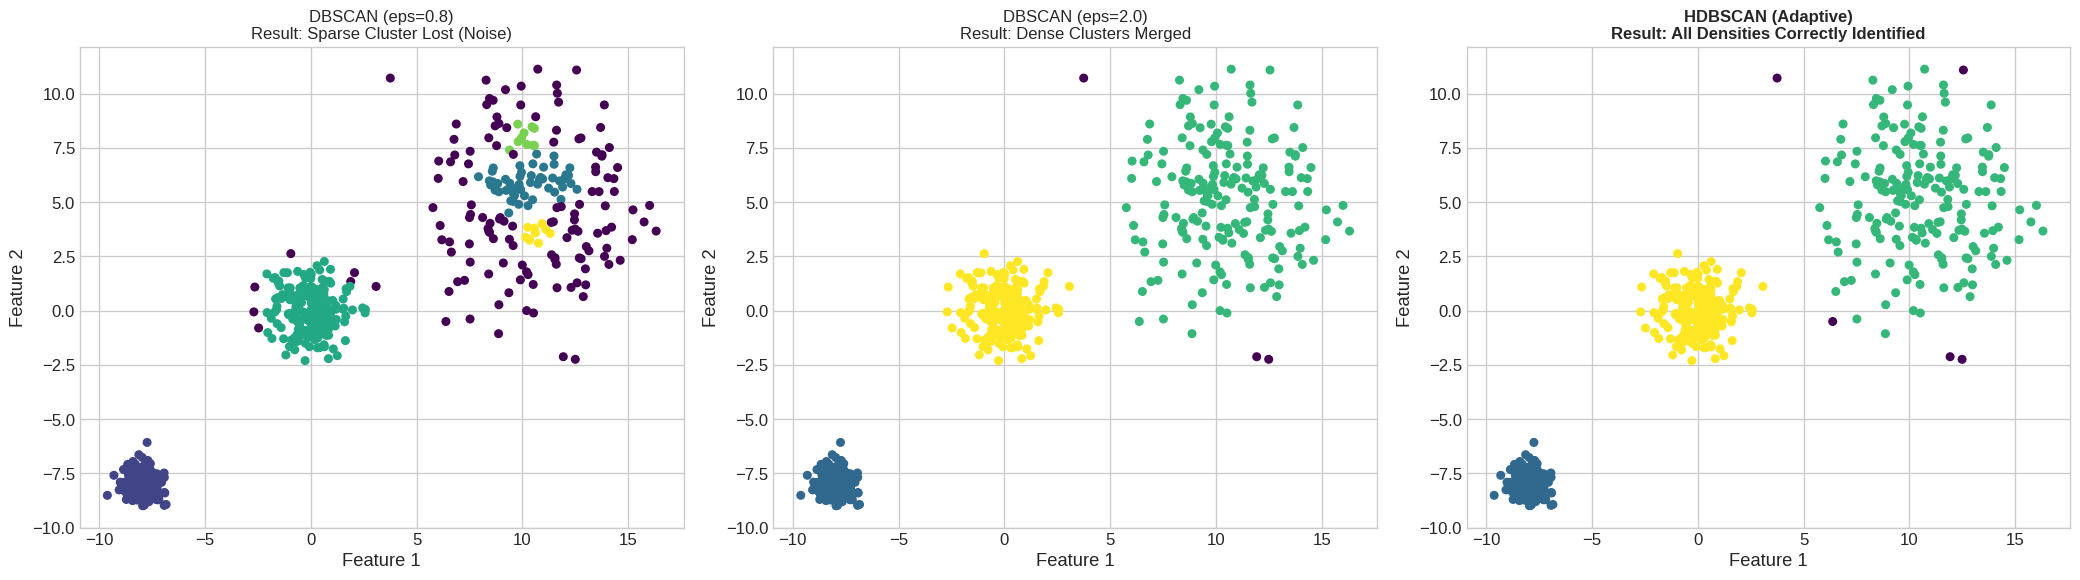

In [20]:
# --- STRATEGY: Multi-Density Synthetic Data Generation ---
# We create a dataset with extreme density variations:
# - Cluster 1: High Density (std=0.5)
# - Cluster 2: Medium Density (std=1.0)
# - Cluster 3: Low Density/Sparse (std=2.5)
X_var, y_var = make_blobs(n_samples=600,
                          centers=[(-8, -8), (0, 0), (10, 5)],
                          cluster_std=[0.5, 1.0, 2.5],
                          random_state=42)

# --- MODEL 1: DBSCAN (Attempts with fixed global thresholds) ---
# Attempt A: Restrictive Epsilon (Targeting dense clusters)
db_small = DBSCAN(eps=0.8, min_samples=10).fit(X_var)

# Attempt B: Permissive Epsilon (Targeting sparse clusters)
db_large = DBSCAN(eps=2.0, min_samples=10).fit(X_var)

# --- MODEL 2: HDBSCAN (Adaptive approach) ---
# No epsilon required. We only specify the minimum cluster size.
hdb_adaptive = hdbscan.HDBSCAN(min_cluster_size=15).fit(X_var)

# --- VISUAL COMPARISON ---
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Plot 1: DBSCAN Small Eps
axes[0].scatter(X_var[:, 0], X_var[:, 1], c=db_small.labels_, cmap='viridis', s=30)
axes[0].set_title("DBSCAN (eps=0.8)\nResult: Sparse Cluster Lost (Noise)", fontsize=12)

# Plot 2: DBSCAN Large Eps
axes[1].scatter(X_var[:, 0], X_var[:, 1], c=db_large.labels_, cmap='viridis', s=30)
axes[1].set_title("DBSCAN (eps=2.0)\nResult: Dense Clusters Merged", fontsize=12)

# Plot 3: HDBSCAN
axes[2].scatter(X_var[:, 0], X_var[:, 1], c=hdb_adaptive.labels_, cmap='viridis', s=30)
axes[2].set_title("HDBSCAN (Adaptive)\nResult: All Densities Correctly Identified", fontsize=12, fontweight='bold')

for ax in axes:
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

### 4.1 Discussion of results and conclusion
The comparative analysis highlights a fundamental topological limitation of fixed-threshold methods:

1.  **The DBSCAN Dilemma:** as shown in the first two plots, it is mathematically impossible to find a single $\epsilon$ value that simultaneously captures the sparse cluster (top-right) and separates the dense clusters (bottom-left). The algorithm is forced to trade off between **segmentation** and **coverage**.

2.  **The HDBSCAN Solution:** the third plot demonstrates that HDBSCAN successfully identifies all three structures. By constructing a hierarchy and selecting stable cuts at **different density levels**, the algorithm effectively adapts to the local geometry of the data.

**Conclusion:**

For datasets with homogeneous density, DBSCAN remains a valid and efficient choice. However, for complex real-world data exhibiting **variable density**, HDBSCAN provides a superior, parameter-robust solution without requiring prior knowledge of the scale of density.